In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2020-11-08 13:54:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   100MB/s    in 0.7s    

2020-11-08 13:54:25 (100 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

In [3]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [4]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [6]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamos el modelo

In [8]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
100/100 [==============================] - 21s 206ms/step - loss: 0.5943 - acc: 0.6905 - val_loss: 0.4744 - val_acc: 0.7830
Epoch 2/3
100/100 [==============================] - 20s 204ms/step - loss: 0.4861 - acc: 0.7830 - val_loss: 0.3926 - val_acc: 0.8170
Epoch 3/3
100/100 [==============================] - 20s 203ms/step - loss: 0.4347 - acc: 0.8045 - val_loss: 0.3763 - val_acc: 0.8190


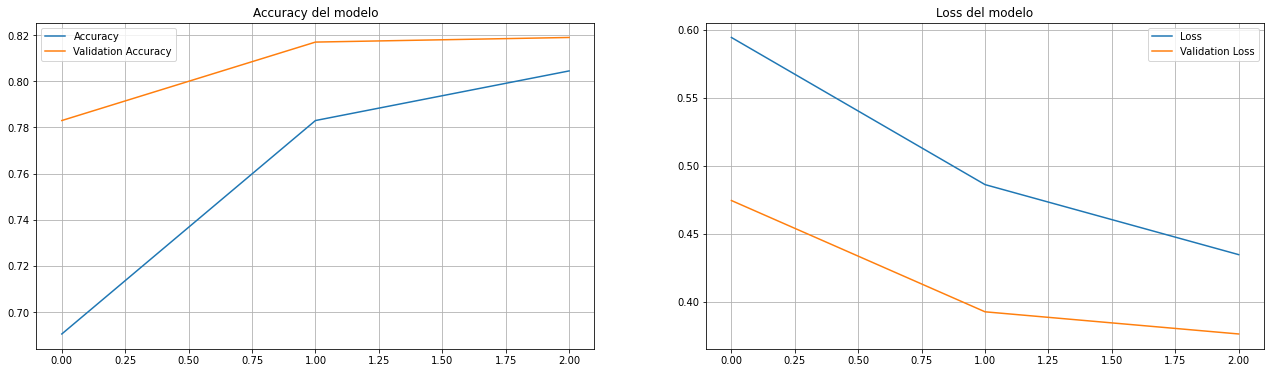

In [24]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize=(22,6))
axes[0].plot(history.history["acc"])
axes[0].plot(history.history['val_acc'])
axes[0].set_title("Accuracy del modelo")
axes[0].legend(["Accuracy","Validation Accuracy"])
axes[0].grid(which="Both")
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title("Loss del modelo")
axes[1].legend(["Loss","Validation Loss"])
axes[1].grid(which="Both")
plt.show()

# TAREA: Hacer lo mismo con ResNet50:

In [36]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
    classes=2 # si include_top=False esto se ignora?
)
### COMPLETAR
base_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
base_resnet.trainable=False 

In [71]:
model = models.Sequential()
model.add(base_resnet)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [72]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [73]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size)

Epoch 1/50
100/100 [==============================] - 21s 209ms/step - loss: 0.7072 - acc: 0.5140 - val_loss: 0.6880 - val_acc: 0.5290
Epoch 2/50
100/100 [==============================] - 20s 198ms/step - loss: 0.6865 - acc: 0.5505 - val_loss: 0.6692 - val_acc: 0.5850
Epoch 3/50
100/100 [==============================] - 20s 199ms/step - loss: 0.6876 - acc: 0.5520 - val_loss: 0.6870 - val_acc: 0.5560
Epoch 4/50
100/100 [==============================] - 20s 200ms/step - loss: 0.6806 - acc: 0.5705 - val_loss: 0.6764 - val_acc: 0.5800
Epoch 5/50
100/100 [==============================] - 20s 199ms/step - loss: 0.6790 - acc: 0.5755 - val_loss: 0.6580 - val_acc: 0.6000
Epoch 6/50
100/100 [==============================] - 20s 200ms/step - loss: 0.6763 - acc: 0.5740 - val_loss: 0.6729 - val_acc: 0.5760
Epoch 7/50
100/100 [==============================] - 20s 200ms/step - loss: 0.6783 - acc: 0.5860 - val_loss: 0.6615 - val_acc: 0.6030
Epoch 8/50
100/100 [==============================] - 2

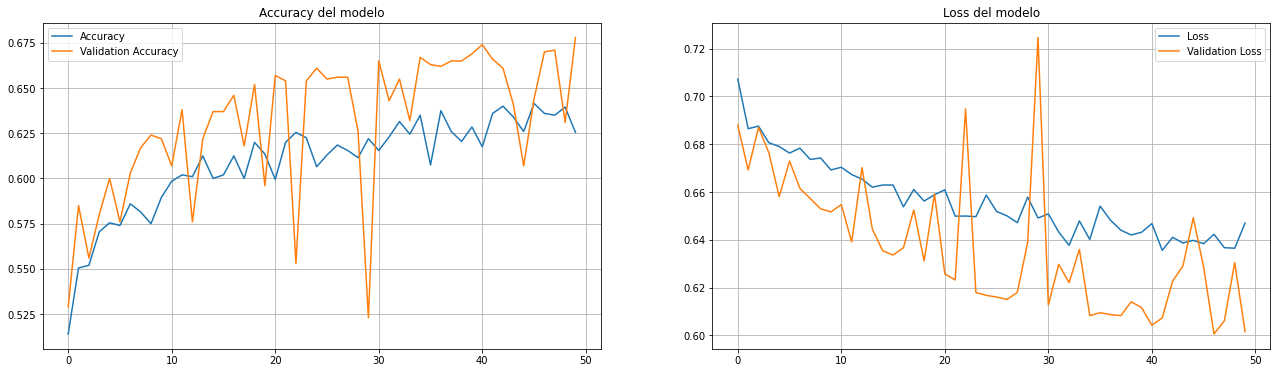

In [74]:
fig,axes = plt.subplots(1,2,figsize=(22,6))
axes[0].plot(history.history["acc"])
axes[0].plot(history.history['val_acc'])
axes[0].set_title("Accuracy del modelo")
axes[0].legend(["Accuracy","Validation Accuracy"])
axes[0].grid(which="Both")
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title("Loss del modelo")
axes[1].legend(["Loss","Validation Loss"])
axes[1].grid(which="Both")
plt.show()

In [75]:
!cp cats_and_dogs_filtered/validation/cats/cat.2053.jpg ejemplo-cat.jpg
!cp cats_and_dogs_filtered/validation/dogs/dog.2053.jpg ejemplo-dog.jpg

[[0.3126226]]
cat


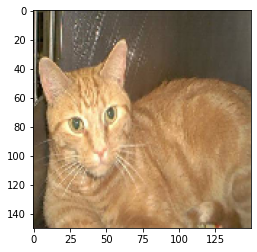

In [76]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_from_img_file(filename):
  img = image.load_img(filename,target_size=(150,150))
  img = np.asarray(img)
  plt.imshow(img)
  img = np.expand_dims(img, axis=0)
  output = model.predict(img)  
  print(output)
  detected_class = "cat" if output[0][0] < 0.5 else "dog"
  print(detected_class)

predict_from_img_file("ejemplo-cat.jpg")

[[0.8950394]]
dog


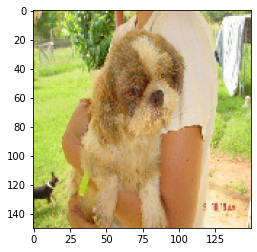

In [77]:
predict_from_img_file("ejemplo-dog.jpg")